# INFO 2950 Project

## Research Question

Our research question/goal is to successfully measuring a NBA player's ability to induce and convert offensive opportunities for himself, as well as leading teammates to those opportunities. In other words, we are attempting to measure how good a player is at creating and efficiently making shots for himself, and at making plays that lead to points for his teammates.

## Data Cleaning

In [3]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [2]:
# Concatenating PBP scoring files
pbp_sc_files = []
for i in np.arange(1,22):
    name = 'pbpstats_export-{}.csv'.format(i)
    file = pd.read_csv(name)
    file['Season'] = 2022-i
    pbp_sc_files.append(file)
pbp_sc = pd.concat(pbp_sc_files)

# Final PBP scoring csv
pbp_sc.to_csv('pbp_sc.csv')

In [3]:
# Concatenating PBP assist files
pbp_as_files = []
for i in np.arange(-42,-21):
    name = 'pbpstats_export-{}.csv'.format(-i)
    file = pd.read_csv(name)
    file['Season'] = 2000-21-i
    pbp_as_files.append(file)    
pbp_as = pd.concat(pbp_as_files)

# Final PBP assist csv
pbp_as.to_csv('pbp_as.csv')

In the above two cells, we combined the individual season PBP scoring and assist, respectively, data CSVs into a single CSV containing the data for every season.

In [4]:
# Reading in csv files
pbp_score = pd.read_csv('pbp_sc.csv')
pbp_assist = pd.read_csv('pbp_as.csv')
nba_pos = pd.read_csv('NBA Players.csv')
seasonStats1950to2017 = pd.read_csv('Season_Stats_1950to2017.csv')
seasonStats2017to2019 = pd.read_csv('Season_Stats_2017to2019.csv')
seasonStats2019to2021 = pd.read_csv('Season_Stats_2019to2021.csv')

Prior to reading in the 2017-2019 and 2019-2021 season data, we had to copy and paste the individual, "raw" data in separate excel sheets into a single sheet for each of those time periods. This is because when data is downloaded from Stahead as a CSV, only 100 entries can be downloaded at a time.

In [5]:
# Drop data from before 2000-2001 season
seasonStats2000to2017 = seasonStats1950to2017[seasonStats1950to2017['Year'] >= 2001]
# Reset index to default so idx doesn't start at some random value
seasonStats2000to2017 = seasonStats2000to2017.reset_index()
# Drop some irrelevant columns
seasonStats2000to2017 = seasonStats2000to2017.drop(['index', 'Unnamed: 0', 'blanl', 'blank2', 'Pos'], axis = 1)
# Change the datatype of year (= season) from float64 to int
seasonStats2000to2017 = seasonStats2000to2017.astype({'Year': int})

Due to the PBP data only going back to the 2000-2001 season, we are limiting the scope of our analysis to just the last 20 NBA seasons. So, in the above cell, we dropped all data from before the 2000-2001 season in our Basketball Reference DataFrame. Additionally, we dropped some unnecessary columns. Finally, we changed the type of the 'Year' values from float64 to int, which is the true type of a year.

In [6]:
# Add missing columns into 2019 to 2021 data
seasonStats2019to2021['FG%'] = round(seasonStats2019to2021['FG']/seasonStats2019to2021['FGA'], 3)
seasonStats2019to2021['2P%'] = round(seasonStats2019to2021['2P']/seasonStats2019to2021['2PA'],3)
seasonStats2019to2021['3P%'] = round(seasonStats2019to2021['3P']/seasonStats2019to2021['3PA'],3)
seasonStats2019to2021['FT%'] = round(seasonStats2019to2021['FT']/seasonStats2019to2021['FTA'],3)
seasonStats2019to2021['eFG%'] = round(((seasonStats2019to2021['FG'] + (0.5*seasonStats2019to2021['3P']))/
                                 seasonStats2019to2021['FGA']),3)
seasonStats2019to2021['TS%'] = round(((seasonStats2019to2021['PTS'])/
                                (2*(seasonStats2019to2021['FGA'])+(0.44*seasonStats2019to2021['FTA']))),3)

In the above cell, we added some columns into our DataFrame containing the 2019-2021 Stathead data that were missing. These columns were present in our DataFrames containing the 2000-2017 and 2017-2019 data.

In [7]:
# Drop extraneous columns from 2017 to 2019 and 2019 to 2021 data
seasonStats2017to2019 = seasonStats2017to2019.drop(['ORtg','DRtg', 'Lg'], axis = 1)
seasonStats2019to2021 = seasonStats2019to2021.drop(['ORtg','DRtg', 'Lg'], axis = 1)

In the above cell, we dropped some unnecessary columns present in the 2017-2019 and 2019-2021 Stathead DataFrames.

In [8]:
# Drop all rows with NaNs from 2017 to 2019 data.
seasonStats2017to2019 = seasonStats2017to2019.dropna(how = 'all')

Here, we had to drop some trailing rows of NaNs that were present at the end of the 2017-2019 Stathead DataFrame.

In [9]:
# Renaming and reordering columns across the 3 dfs
seasonStats2000to2017 = seasonStats2000to2017.rename(columns = {'Year': 'Season'})
cols = list(seasonStats2000to2017.columns)
seasonStats2017to2019 = seasonStats2017to2019[cols]
seasonStats2019to2021 = seasonStats2019to2021[cols]

In the above cell, we had to rename the 'Year' column in the 2000-2017 Dataframe to match the corresponding column title in the 2017-2019 and 2019-2021 DataFrames. Additionally, we reordered the columns in the 2017-2019 and 2019-2021 DataFrames to match the other DataFrame. This will ease the process of combining the three DataFrames.

In [10]:
# Converting Season column values to be same across the 3 dfs
for i in np.arange(len(seasonStats2017to2019)):
    seasonStats2017to2019.loc[i,'Season'] = int(seasonStats2017to2019.loc[i,'Season'][-2:])+2000

for i in np.arange(len(seasonStats2019to2021)):
    seasonStats2019to2021.loc[i,'Season'] = int(seasonStats2019to2021.loc[i,'Season'][-2:])+2000

In the above cell, we converted the 'Season' column values in two of the three DataFrames so that they would match across all three. Once again, this will simplify the process of combining the three DataFrames.

In [11]:
# Combining the 3 df into a single Stathead df
seasonStats = [seasonStats2000to2017,seasonStats2017to2019,seasonStats2019to2021]
nba = pd.concat(seasonStats)

Here, we actually perform the concatenation, creating a single DataFrame corresponding to all of our Stathead/Basketball Reference data.

In [12]:
# Cleaning Team Names
nba = nba.rename(columns = {'tm': 'team'})
nba.columns = [header.lower() for header in nba.columns]

# Changing team abbreviations to match modern versions
nba = nba.replace({'team':{
    'CHO': 'CHA',
    'CHH': 'CHA',
    'BRK': 'BKN',
    'NJN': 'BKN',
    'VAN': 'MEM',
    'PHO': 'PHX',
    'NOH': 'NOP',
    'NOK': 'NOP',
    'SEA': 'OKC',
}})

In the above cell, we changed team abbreivations to match modern versions. Thus, there will be 31 values corresponding to team, representing each of the 30 NBA franchise present in our dataset (no defunct teams are apart of our dataset) and a 31st value 'TOT', which means the player played for multiple teams that season.

In [13]:
# Adding percentage of games started
nba.insert(6,'gs%',(nba.gs/nba.g).round(decimals=3))

In [14]:
# Addressing player names with accents
names = nba.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba.player = names

In the above cell, we standardized player names, particularly those with accents, which were handled differently by the differently by Stathead and PBP.

In [15]:
# Removing duplicate rows with players playing for multiple teams in one season
# Keeping row of aggregate stats for that player for that season
nba = nba.drop_duplicates(subset = ['player','season'])

Players who switched teams in the middle of a season had entires in our Stathead/Basketball Reference DataFrame for both their overall season numbers, and their splits for each team they played for. This cell drops the extra entries, which correspond to their team splits, and keeps just their season-long numbers.

In [16]:
# 70% mins cutoff
mins70 = list(nba.groupby('season').mp.quantile(q=0.3))
all_bl = [False]*len(nba)
year = 2001
for i in np.arange(len(mins70)):
    bl = np.logical_and(nba.season==year , nba.mp > mins70[i])
    all_bl = np.logical_or(all_bl, bl)
    year += 1

In [17]:
# Assigning final rows of df
nba_filtered = nba.loc[all_bl]

In the above two cells, we remove all players who were not above the 30th percentile in minutes played in a particular season. This is due to a few reasons. The first, and primary, reason is because some of our data was not available for many players whose minutes played placed them below the cutoff. Additionally, per-possession and existing advanced statistics are subject to extreme noise when examined for players with lower amounts of minutes played, as these small sample sizes are not representative of a player’s true ability and are often strongly influenced by external factors.

In [18]:
# Change datatypes of certain columns to match their true type
nba_filtered = nba_filtered.astype({'season': int, 'age': int, 'g': int, 'gs': int, 'mp': int, 'fg': int, 'fga': int,
                                  '3p': int, '3pa': int, '2p': int, '2pa': int, 'ft': int, 'fta': int, 'orb': int,
                                  'drb': int, 'trb': int, 'ast': int, 'stl': int, 'blk': int, 'tov': int, 'pf': int,
                                  'pts': int})
nba_filtered.head()

,season,player,age,tm,g,gs,gs%,mp,per,ts%,...,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
2,2001,Shareef Abdur-Rahim,24,VAN,81,81,1.000,3241,19.1,0.549,...,0.834,175,560,735,250,90,77,231,238,1663
4,2001,Courtney Alexander,23,TOT,65,24,0.369,1382,11.6,0.484,...,0.820,42,101,143,62,45,5,75,139,618
7,2001,Ray Allen,25,MIL,82,82,1.000,3129,22.9,0.610,...,0.888,101,327,428,374,124,20,204,192,1806
9,2001,John Amaechi,30,ORL,82,36,0.439,1710,8.7,0.455,...,0.631,77,191,268,74,28,29,124,175,650
10,2001,Derek Anderson,26,SAS,82,82,1.000,2859,17.1,0.542,...,0.851,75,288,363,301,120,14,165,188,1269


In the above cell, we changed the datatype of certain columns to reflect their true type. When our data was read in, these columns all had the datatype float64, which is nonsensical.

In [19]:
# Drop some irrelevant, unnecessary, and/or redundant columns from PBP data
pbp_score = pbp_score.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Points','FG2M', 'FG2A',
                            'Fg2Pct', 'FG3M', 'FG3A', 'Fg3Pct', 'FG3APct','EfgPct', 'TsPct','Usage'], axis = 1)
pbp_assist = pbp_assist.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Assists'], axis = 1)

Here, we dropped columns which were either irrelevant, unnecessary, or redundant from our PBP DataFrames.

In [20]:
# Tidying up columns in PBP data
pbp_score.columns = [header.lower() for header in pbp_score.columns]
pbp_assist.columns = [header.lower() for header in pbp_assist.columns]

In [21]:
# Rename name to player for pbp
pbp_score = pbp_score.rename(columns = {'name' : 'player'})
pbp_assist = pbp_assist.rename(columns = {'name' : 'player'})

# Merge 2 pbp files
pbp = pbp_score.merge(pbp_assist)

In the prior cell, we changed the name of the 'name' column to 'player' in our PBP DataFrames to match the corresponding column name in the Stathead/Basketball Reference DataFrame. Additionally, we merged the two PBP DataFrames to make one PBP DataFrame containing both the scoring and assist data.

In [22]:
# Merge dfs from the 2 different datasets to create single df
nba_1 = nba_filtered.merge(pbp, how = 'inner', on = ['player', 'season'])

Here, we merged our Stathead/Basketball Reference and PBP DataFrames to one, comprehensive DataFrame.

In [23]:
# Adjusting player names of nba player position df
pos_names = nba_pos.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba_pos.player = pos_names
# Assigning position to corresponding player
nba = nba_1.merge(nba_pos, on = 'player', how = 'left')

Earlier, we removed the column containing player position in our Stathead/Basketball Reference 2000-2017 DataFrame because it was not present in any of the other datasheets we were going to be working with. However, because having the position for each player could enhance our analysis, we added it to our final DataFrame in the above cell.

In [24]:
# Manually adding position of 1 player, Omer Asik, whose position was missing from the csv
omer_i = list(nba.loc[nba.pos.isnull()].index)
nba.loc[omer_i,'pos'] = "C"

Our position DataFrame had one missing value: it did not include the position for Omer Asik. In the above cell, we manually added it in.

In [25]:
nba.columns

Index(['season', 'player', 'age', 'tm', 'g', 'gs', 'gs%', 'mp', 'per', 'ts%',
       '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%',
       'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp',
       'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%',
       'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts', 'offposs', 'nonheavefg3pct', 'ftpoints', 'ptsassisted2s',
       'ptsunassisted2s', 'ptsassisted3s', 'ptsunassisted3s', 'assisted2spct',
       'nonputbacksassisted2spct', 'assisted3spct', 'shotqualityavg',
       'ptsputbacks', 'fg2ablocked', 'fg2apctblocked', 'fg3ablocked',
       'fg3apctblocked', 'assistpoints', 'twoptassists', 'threeptassists',
       'atrimassists', 'shortmidrangeassists', 'longmidrangeassists',
       'corner3assists', 'arc3assists', 'pos'],
      dtype='object')

In [136]:
# Read in csv containing league average team shooting stats for the 2000-2001 to the 2020-2021 season.
lg_avg_shooting = pd.read_csv('NBA Team Shooting Lg Avgs 2001-2021.csv')
lg_avg_shooting.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,% of FGA by Distance,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,% of FG Ast'd,Unnamed: 18,Dunks,Unnamed: 20,Corner,Unnamed: 22,Heaves,Unnamed: 24
0,Season,G,MP,FG%,Dist.,2P,0-3 ft,10-Mar,16-Oct,16-3pt,...,16-3pt,3P,2P,3P,%FGA,Md.,%3PA,3P%,Att.,Md.
1,2021,72,17381,0.466,14.1,0.608,0.254,0.186,0.096,0.072,...,0.409,0.367,0.502,0.826,0.054,303,0.222,0.395,10.5,0.3
2,2020,71,17061,0.46,13.9,0.616,0.282,0.165,0.093,0.077,...,0.404,0.358,0.504,0.815,0.059,330,0.211,0.39,13.9,0.3
3,2019,82,19818,0.461,13.5,0.641,0.292,0.162,0.096,0.092,...,0.401,0.355,0.513,0.823,0.058,380,0.214,0.383,15.7,0.5
4,2018,82,19795,0.46,13.2,0.663,0.281,0.156,0.106,0.12,...,0.4,0.362,0.499,0.83,0.053,331,0.208,0.394,17.5,0.2


In the above cell, we imported league average team shooting statistics for all seasons from 2000-2001 to 2020-2021. To get this data in this form, we went to Basketball Reference's season summary page for every season in the previously mentioned range, and copied the column values for the observation "League Average" in the "Shooting Stats" table. As can be seen from the above output, this data is in desperate need of cleaning.

In [137]:
# Removing the non-sense column names and replacing them with the first observation in 
# the df, which corresponds to the true column names.
new_col_names = lg_avg_shooting.loc[0,:]
lg_avg_shooting.columns = new_col_names
# Removing the first row in the df, which does not correspond to an actual observation/season.
lg_avg_shooting = lg_avg_shooting.loc[1:,:]
lg_avg_shooting.head()

,Season,G,MP,FG%,Dist.,2P,0-3 ft,10-Mar,16-Oct,16-3pt,...,16-3pt,3P,2P,3P,%FGA,Md.,%3PA,3P%,Att.,Md.
1,2021,72,17381,0.466,14.1,0.608,0.254,0.186,0.096,0.072,...,0.409,0.367,0.502,0.826,0.054,303,0.222,0.395,10.5,0.3
2,2020,71,17061,0.46,13.9,0.616,0.282,0.165,0.093,0.077,...,0.404,0.358,0.504,0.815,0.059,330,0.211,0.39,13.9,0.3
3,2019,82,19818,0.461,13.5,0.641,0.292,0.162,0.096,0.092,...,0.401,0.355,0.513,0.823,0.058,380,0.214,0.383,15.7,0.5
4,2018,82,19795,0.46,13.2,0.663,0.281,0.156,0.106,0.12,...,0.4,0.362,0.499,0.83,0.053,331,0.208,0.394,17.5,0.2
5,2017,82,19815,0.457,13.3,0.684,0.29,0.152,0.099,0.142,...,0.403,0.358,0.495,0.835,0.051,332,0.228,0.388,16.8,0.3


In [138]:
# First, tidy up league_avg_shooting column names, and add in information about each variable lost by 
# changing the original column names.
lg_avg_shooting = lg_avg_shooting.rename(columns = {'Dist.': 'dist (ft)', '2P': 'pct_FGA_2P', '0-3 ft': 
                                                    'pct_FGA_0to3_ft', '10-Mar': 'pct_FGA_3to10_ft', 
                                                    '16-Oct': 'pct_FGA_10to16_ft', '16-3pt': 'pct_FGA_16ftto3PT',
                                                    '3P': 'pct_FGA_3PT', '2P': 'pct_2PM', '0-3': 'pct_FGM_0to3_ft', 
                                                    '10-Mar': 'pct_FGM_3to10_ft', '16-Oct': 'pct_FGM_10to16_ft',
                                                    '16-3pt': 'pct_FGM_16ftto3PT', '3P': 'pct_3PM', 
                                                    '2P': 'pct_2PM_assisted', '3P': 'pct_3PM_assisted', 
                                                    '%FGA': 'pct_FGA_dunks', 'Md.': 'dunks_made', 
                                                    '%3PA': 'pct_3PA_corner', '3P%': 'pct_3PM_corner', 
                                                    'Att.': 'heaves_att', 'Md.': 'heaves_made'})
# Because some columns have the same name, some of our columns did not receive their desired name, 
# receiving their counterpart's name as well. This occur for columns with original names '2P','3P', '10-Mar', '16-Oct'
# '16-3pt', and 'Md.'.
duplicates_idx = lg_avg_shooting.columns.duplicated(keep = 'last')
print(lg_avg_shooting.columns[duplicates_idx])
# Examining the printed output from the above line, we notice that the first instance of each duplicate must be 
# the one needed to be changed. We will change them directly to avoid the same issue.
shooting_cols = list(lg_avg_shooting.columns)
shooting_cols[5] = 'pct_FGA_2P'
shooting_cols[7] = 'pct_FGA_3to10_ft'
shooting_cols[8] = 'pct_FGA_10to16_ft'
shooting_cols[9] = 'pct_FGA_16ftto3PT'
shooting_cols[10] = 'pct_FGA_3PT'
shooting_cols[11] = 'pct_2PM'
shooting_cols[16] = 'pct_3PM'
shooting_cols[20] = 'dunks_made'
lg_avg_shooting.columns = shooting_cols

Index(['pct_2PM_assisted', 'pct_FGM_3to10_ft', 'pct_FGM_10to16_ft',
       'pct_FGM_16ftto3PT', 'pct_3PM_assisted', 'pct_2PM_assisted',
       'pct_3PM_assisted', 'heaves_made'],
      dtype='object', name=0)


In [139]:
print(lg_avg_shooting.columns)

Index(['Season', 'G', 'MP', 'FG%', 'dist (ft)', 'pct_FGA_2P',
       'pct_FGA_0to3_ft', 'pct_FGA_3to10_ft', 'pct_FGA_10to16_ft',
       'pct_FGA_16ftto3PT', 'pct_FGA_3PT', 'pct_2PM', 'pct_FGM_0to3_ft',
       'pct_FGM_3to10_ft', 'pct_FGM_10to16_ft', 'pct_FGM_16ftto3PT', 'pct_3PM',
       'pct_2PM_assisted', 'pct_3PM_assisted', 'pct_FGA_dunks', 'dunks_made',
       'pct_3PA_corner', 'pct_3PM_corner', 'heaves_att', 'heaves_made'],
      dtype='object')


In the above cells, we begin tidying up league_avg_shooting's column names. We did this before dropping the irrelevant or unnecessary columns so it would be clear what exactly we were dropping.

In [140]:
# Now, dropping the columns that we are certain are irrelevant or unnecessary to our analysis.
lg_avg_shooting = lg_avg_shooting.drop(['G', 'MP', 'FG%', 'dist (ft)', 'pct_FGA_0to3_ft','pct_FGA_16ftto3PT', 
                                        'pct_FGA_3PT', 'pct_FGA_dunks', 'dunks_made','heaves_att', 'heaves_made'],
                                       axis = 1)
# Making all columns lowercase...
lg_avg_shooting.columns = [col_name.lower() for col_name in lg_avg_shooting.columns]
print(lg_avg_shooting.columns)

Index(['season', 'pct_fga_2p', 'pct_fga_3to10_ft', 'pct_fga_10to16_ft',
       'pct_2pm', 'pct_fgm_0to3_ft', 'pct_fgm_3to10_ft', 'pct_fgm_10to16_ft',
       'pct_fgm_16ftto3pt', 'pct_3pm', 'pct_2pm_assisted', 'pct_3pm_assisted',
       'pct_3pa_corner', 'pct_3pm_corner'],
      dtype='object')


In the above cell, we dropped irrelevant, unnecessary columns from our league average team shooting stats DataFrame and made all of our remaining columns lowercase.

In [141]:
# Finally, let's examine the datatype of each column in league_avg_shooting...
print(lg_avg_shooting.dtypes)

season               object
pct_fga_2p           object
pct_fga_3to10_ft     object
pct_fga_10to16_ft    object
pct_2pm              object
pct_fgm_0to3_ft      object
pct_fgm_3to10_ft     object
pct_fgm_10to16_ft    object
pct_fgm_16ftto3pt    object
pct_3pm              object
pct_2pm_assisted     object
pct_3pm_assisted     object
pct_3pa_corner       object
pct_3pm_corner       object
dtype: object


In [142]:
# Looking at the output directly above this cell, we can see that none of our variables' current datatypes 
# are the same as their true datatypes. Let's fix this:
lg_avg_shooting = lg_avg_shooting.astype({'season': int, 'pct_2pm': float, 'pct_fgm_0to3_ft': float, 
                                           'pct_fgm_3to10_ft': float, 'pct_fgm_10to16_ft': float, 
                                           'pct_fgm_16ftto3pt': float, 'pct_3pm': float, 'pct_2pm_assisted': float, 
                                           'pct_3pm_assisted': float, 'pct_3pm_corner': float, 
                                           'pct_3pa_corner': float, 'pct_fga_2p': float, 'pct_fga_3to10_ft': float,
                                           'pct_fga_10to16_ft': float})
print(lg_avg_shooting.dtypes)

season                 int64
pct_fga_2p           float64
pct_fga_3to10_ft     float64
pct_fga_10to16_ft    float64
pct_2pm              float64
pct_fgm_0to3_ft      float64
pct_fgm_3to10_ft     float64
pct_fgm_10to16_ft    float64
pct_fgm_16ftto3pt    float64
pct_3pm              float64
pct_2pm_assisted     float64
pct_3pm_assisted     float64
pct_3pa_corner       float64
pct_3pm_corner       float64
dtype: object


In the above cells, we altered the datatypes of the columns in our league average team shooting stats DataFrame to match their true datatypes.

In [120]:
# Read in csv containing data on NBA team statistics for seasons from 2000 to 2021.
teamstats = pd.read_csv('teamstats.csv')

In the above cell, we imported team statistics from each team in the league for all seasons from 2000-2001 to 2020-2021. To get this data in this form, we exported season-long team statistics from the season summary page of Basketball Reference. We then concatenated each season's data into a single csv file for ease of use.

In [121]:
# Cleaning
teamstats.reset_index()
keep_cols = ['Rk', 'Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg',
       'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'eFG%',
       'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1', 'DRB%',
       'FT/FGA.1', 'Attend.', 'Attend./G', 'Season']
teamstats = teamstats.loc[teamstats.Team != 'League Average',keep_cols]

teamstats.columns = [header.lower() for header in teamstats.columns]
teamstats = teamstats.rename(columns={
    'rk' : 'rank',
    'w' : 'wins',
    'l' : 'losses'})

# Team Names
teamstats.team = [team.replace('*','') for team in teamstats.team]
teamstats = teamstats.replace({'team':{
    'San Antonio Spurs':'SAS','Sacramento Kings':'SAC','Utah Jazz':'UTA','Philadelphia 76ers':'PHI',
    'Portland Trail Blazers':'POR','Dallas Mavericks':'DAL','Milwaukee Bucks':'MIL',
    'Los Angeles Lakers':'LAL','New York Knicks':'NYK','Miami Heat':'MIA','Toronto Raptors':'TOR',
    'Houston Rockets':'HOU','Charlotte Hornets':'CHA','Phoenix Suns':'PHX',
    'Minnesota Timberwolves':'MIN','Orlando Magic':'ORL','Seattle SuperSonics':'OKC',
    'Indiana Pacers':'IND','Detroit Pistons':'DET','Boston Celtics':'BOS','Denver Nuggets':'DEN',
    'Los Angeles Clippers':'LAC','Cleveland Cavaliers':'CLE','New Jersey Nets':'BKN',
    'Atlanta Hawks':'ATL','Vancouver Grizzlies':'MEM','Washington Wizards':'WAS',
    'Golden State Warriors':'GSW','Chicago Bulls':'CHI','Memphis Grizzlies':'MEM',
    'New Orleans Hornets':'NOP','Charlotte Bobcats':'CHA','New Orleans/Oklahoma City Hornets':'NOP',
    'Oklahoma City Thunder':'OKC','Brooklyn Nets':'BKN','New Orleans Pelicans':'NOP'
}})

In the cell above, we remove certain unnecessary columns and also the rows for the league average values of a given season. We then update each team name to its modern day franchise's abbreviation so that this data is compatible with the other datasets we are using.

In [122]:
# Converting values to appropriate data types
teamstats = teamstats.astype({
    'rank' : int, 'age' : int, 'wins' : int, 'losses' : int})

In the above cell, we altered the datatypes of the columns in our DataFrame to match their true datatypes.

In [123]:
# Reading in a csv containing league average team statistics by season...
lg_avg_teamstats = pd.read_csv('NBA Team Lg Avg Data 1949-2021.csv')
lg_avg_teamstats.head()

,Unnamed: 0,Unnamed: 1,Per Game,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Shooting,Unnamed: 19,Unnamed: 20,Advanced,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Season,G,MP,FG,FGA,3P,3PA,FT,FTA,ORB,...,PTS,FG%,3P%,FT%,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg
1,2020-21,1080,241.4,41.2,88.4,12.7,34.6,17,21.8,9.8,...,112.1,0.466,0.367,0.778,99.2,0.538,12.4,22.2,0.192,112.3
2,2019-20,1059,241.8,40.9,88.8,12.2,34.1,17.9,23.1,10.1,...,111.8,0.46,0.358,0.773,100.3,0.529,12.8,22.5,0.201,110.6
3,2018-19,1230,241.6,41.1,89.2,11.4,32,17.7,23.1,10.3,...,111.2,0.461,0.355,0.766,100,0.524,12.4,22.9,0.198,110.4
4,2017-18,1230,241.4,39.6,86.1,10.5,29,16.6,21.7,9.7,...,106.3,0.46,0.362,0.767,97.3,0.521,13,22.3,0.193,108.6


In [124]:
# Removing the non-sense column names and replacing them with the first observation in 
# the df, which corresponds to the true column names.
new_col_names2 = lg_avg_teamstats.loc[0,:]
lg_avg_teamstats.columns = new_col_names2
# Removing the first row in the df, which does not correspond to an actual observation/season.
lg_avg_teamstats = lg_avg_teamstats.loc[1:,:]
lg_avg_teamstats.head()

,Season,G,MP,FG,FGA,3P,3PA,FT,FTA,ORB,...,PTS,FG%,3P%,FT%,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg
1,2020-21,1080,241.4,41.2,88.4,12.7,34.6,17,21.8,9.8,...,112.1,0.466,0.367,0.778,99.2,0.538,12.4,22.2,0.192,112.3
2,2019-20,1059,241.8,40.9,88.8,12.2,34.1,17.9,23.1,10.1,...,111.8,0.46,0.358,0.773,100.3,0.529,12.8,22.5,0.201,110.6
3,2018-19,1230,241.6,41.1,89.2,11.4,32,17.7,23.1,10.3,...,111.2,0.461,0.355,0.766,100,0.524,12.4,22.9,0.198,110.4
4,2017-18,1230,241.4,39.6,86.1,10.5,29,16.6,21.7,9.7,...,106.3,0.46,0.362,0.767,97.3,0.521,13,22.3,0.193,108.6
5,2016-17,1230,241.6,39,85.4,9.7,27,17.8,23.1,10.1,...,105.6,0.457,0.358,0.772,96.4,0.514,12.7,23.3,0.209,108.8


In [125]:
lg_avg_teamstats = lg_avg_teamstats.reset_index()
# Removing all unneccesary observations (seasons not present in our dataset) and columns...
lg_avg_teamstats = lg_avg_teamstats.iloc[0:21, :]
# Removing all columns we know to be unnecessary or redundant from our df lg_avg_teamstats...
lg_avg_teamstats = lg_avg_teamstats.drop(columns = ['index', 'G', 'MP', 'ORB', 'DRB', 'STL', 
                                                    'BLK', 'TRB', 'FT%', 'PF', 'ORB%'] )
lg_avg_teamstats

,Season,FG,FGA,3P,3PA,FT,FTA,AST,TOV,PTS,FG%,3P%,Pace,eFG%,TOV%,FT/FGA,ORtg
0,2020-21,41.2,88.4,12.7,34.6,17,21.8,24.8,13.8,112.1,0.466,0.367,99.2,0.538,12.4,0.192,112.3
1,2019-20,40.9,88.8,12.2,34.1,17.9,23.1,24.4,14.5,111.8,0.46,0.358,100.3,0.529,12.8,0.201,110.6
2,2018-19,41.1,89.2,11.4,32,17.7,23.1,24.6,14.1,111.2,0.461,0.355,100,0.524,12.4,0.198,110.4
3,2017-18,39.6,86.1,10.5,29,16.6,21.7,23.2,14.3,106.3,0.46,0.362,97.3,0.521,13,0.193,108.6
4,2016-17,39,85.4,9.7,27,17.8,23.1,22.6,14,105.6,0.457,0.358,96.4,0.514,12.7,0.209,108.8
5,2015-16,38.2,84.6,8.5,24.1,17.7,23.4,22.3,14.4,102.7,0.452,0.354,95.8,0.502,13.2,0.209,106.4
6,2014-15,37.5,83.6,7.8,22.4,17.1,22.8,22,14.4,100,0.449,0.35,93.9,0.496,13.3,0.205,105.6
7,2013-14,37.7,83,7.7,21.5,17.8,23.6,22,14.6,101,0.454,0.36,93.9,0.501,13.6,0.215,106.6
8,2012-13,37.1,82,7.2,20,16.7,22.2,22.1,14.6,98.1,0.453,0.359,92,0.496,13.7,0.204,105.8
9,2011-12,36.5,81.4,6.4,18.4,16.9,22.5,21,14.6,96.3,0.448,0.349,91.3,0.487,13.8,0.208,104.6


In [126]:
# Converting Season column values to be the same as in our other dfs
for i in np.arange(len(lg_avg_teamstats)):
    lg_avg_teamstats.loc[i,'Season'] = int(lg_avg_teamstats.loc[i,'Season'][-2:])+2000
# Making all columns lowercase
lg_avg_teamstats.columns = [j.lower() for j in lg_avg_teamstats.columns]
lg_avg_teamstats

,season,fg,fga,3p,3pa,ft,fta,ast,tov,pts,fg%,3p%,pace,efg%,tov%,ft/fga,ortg
0,2021,41.2,88.4,12.7,34.6,17,21.8,24.8,13.8,112.1,0.466,0.367,99.2,0.538,12.4,0.192,112.3
1,2020,40.9,88.8,12.2,34.1,17.9,23.1,24.4,14.5,111.8,0.46,0.358,100.3,0.529,12.8,0.201,110.6
2,2019,41.1,89.2,11.4,32,17.7,23.1,24.6,14.1,111.2,0.461,0.355,100,0.524,12.4,0.198,110.4
3,2018,39.6,86.1,10.5,29,16.6,21.7,23.2,14.3,106.3,0.46,0.362,97.3,0.521,13,0.193,108.6
4,2017,39,85.4,9.7,27,17.8,23.1,22.6,14,105.6,0.457,0.358,96.4,0.514,12.7,0.209,108.8
5,2016,38.2,84.6,8.5,24.1,17.7,23.4,22.3,14.4,102.7,0.452,0.354,95.8,0.502,13.2,0.209,106.4
6,2015,37.5,83.6,7.8,22.4,17.1,22.8,22,14.4,100,0.449,0.35,93.9,0.496,13.3,0.205,105.6
7,2014,37.7,83,7.7,21.5,17.8,23.6,22,14.6,101,0.454,0.36,93.9,0.501,13.6,0.215,106.6
8,2013,37.1,82,7.2,20,16.7,22.2,22.1,14.6,98.1,0.453,0.359,92,0.496,13.7,0.204,105.8
9,2012,36.5,81.4,6.4,18.4,16.9,22.5,21,14.6,96.3,0.448,0.349,91.3,0.487,13.8,0.208,104.6


In [127]:
# Finally, let's examine the datatypes of the columns in our lg_avg_teamstats df.
print(lg_avg_teamstats.dtypes)

season    object
fg        object
fga       object
3p        object
3pa       object
ft        object
fta       object
ast       object
tov       object
pts       object
fg%       object
3p%       object
pace      object
efg%      object
tov%      object
ft/fga    object
ortg      object
dtype: object


In [128]:
# Looking at the output directly above this cell, we can see that none of our variables' current datatypes 
# are the same as their true datatypes. Let's fix this:
lg_avg_teamstats = lg_avg_teamstats.astype({'season': int, 'fg': float, 'fga': float, '3p': float, '3pa': float, 
                                           'ft': float, 'fta': float, 'ast': float, 'tov': float, 'pts': float, 
                                           'fg%': float, '3p%': float, 'pace': float,'efg%': float, 'tov%': float, 
                                           'ft/fga': float, 'ortg': float})
print(lg_avg_teamstats.dtypes)

season      int64
fg        float64
fga       float64
3p        float64
3pa       float64
ft        float64
fta       float64
ast       float64
tov       float64
pts       float64
fg%       float64
3p%       float64
pace      float64
efg%      float64
tov%      float64
ft/fga    float64
ortg      float64
dtype: object


In [129]:
# Now, before continuning, for all of our dfs besides nba, let's set (at least one) index to be the season column.
lg_avg_shooting = lg_avg_shooting.set_index('season')
lg_avg_teamstats = lg_avg_teamstats.set_index('season')
teamstats['index'] = teamstats.index
teamstats = teamstats.set_index(['index','season'])
# One example of what we just did...
teamstats

,,rank,team,age,wins,losses,pw,pl,mov,sos,srs,...,efg%,tov%,orb%,ft/fga,efg%.1,tov%.1,drb%,ft/fga.1,attend.,attend./g
index,season,,,,,,,,,,,,,,,,,,,,,
0,2001,1,SAS,29,58,24,63,19,7.76,0.16,7.92,...,0.496,13.6,27.1,0.267,0.444,12.9,73.7,0.182,913176.0,22273.0
1,2001,2,SAC,27,55,27,57,25,5.82,0.25,6.07,...,0.484,13.4,27.2,0.230,0.460,14.5,70.7,0.181,709997.0,17317.0
2,2001,3,UTA,32,53,29,55,27,4.70,0.31,5.00,...,0.497,15.1,30.2,0.273,0.473,15.6,73.2,0.301,792196.0,19322.0
3,2001,4,PHI,28,56,26,54,28,4.28,-0.65,3.64,...,0.468,14.7,31.2,0.262,0.460,14.5,72.5,0.186,805692.0,19651.0
4,2001,5,POR,30,50,32,53,29,4.20,0.33,4.52,...,0.497,14.8,30.0,0.225,0.470,14.3,72.4,0.223,831376.0,20277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,2021,26,MIN,23,23,49,24,48,-5.56,0.31,-5.25,...,0.520,12.4,22.7,0.193,0.556,13.3,76.8,0.207,15774.0,438.0
642,2021,27,HOU,26,17,55,20,52,-7.90,0.40,-7.50,...,0.521,13.0,19.8,0.187,0.555,12.9,77.1,0.201,117009.0,3250.0
643,2021,28,CLE,24,22,50,18,54,-8.44,0.25,-8.19,...,0.508,13.9,23.6,0.194,0.556,13.0,76.6,0.183,91476.0,2541.0


## Exploratory Data Analysis

In [78]:
# Summary Statistics Generator of main player values and statistics
def sumstat(varlist):
    for x in varlist:
        # Stats
        mean, med, std = (nba.loc[:,x].mean(), nba.loc[:,x].median(), nba.loc[:,x].std())
        print(f'''
        Summary Stats of: {x}
        Mean: {mean : .2f}
        Median: {med : .2f}
        Standard Deviation: {std : .2f}
        ''')
        # Hist
        num_bins = 50
        fig, axes = plt.subplots()
        n, bins, patches = axes.hist(nba.loc[:,x], num_bins, density=True)
        # Best fit line
        y = ((1 / (np.sqrt(2 * np.pi) * std)) *
             np.exp(-0.5 * (1 / std * (bins - mean))**2))
        axes.set_xlabel(x)
        axes.plot(bins, y, '-')
        plt.tight_layout()
        plt.show()
    # Correlation Matrix
    sns.heatmap(nba.loc[:,varlist].corr(), center=0, cmap='coolwarm')
    plt.tight_layout()
    plt.show()


        Summary Stats of: g
        Mean:  65.58
        Median:  68.00
        Standard Deviation:  14.04
        


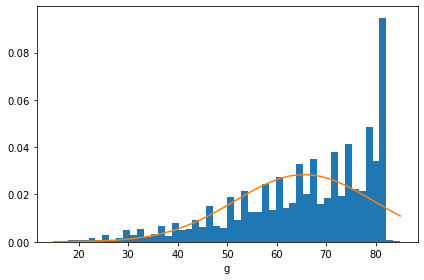


        Summary Stats of: offposs
        Mean:  3223.89
        Median:  3135.00
        Standard Deviation:  1357.72
        


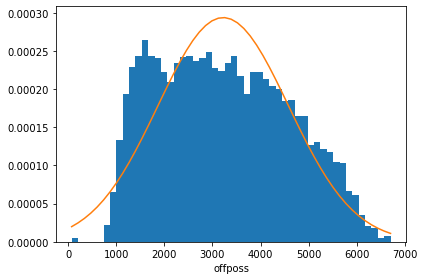


        Summary Stats of: ts%
        Mean:  0.54
        Median:  0.54
        Standard Deviation:  0.05
        


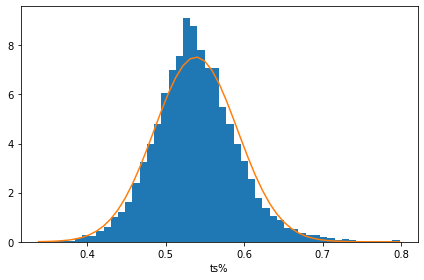


        Summary Stats of: assistpoints
        Mean:  352.37
        Median:  254.00
        Standard Deviation:  309.42
        


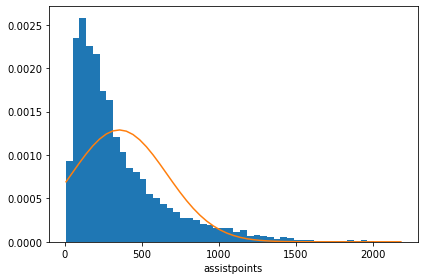


        Summary Stats of: ptsunassisted2s
        Mean:  198.94
        Median:  144.00
        Standard Deviation:  169.92
        


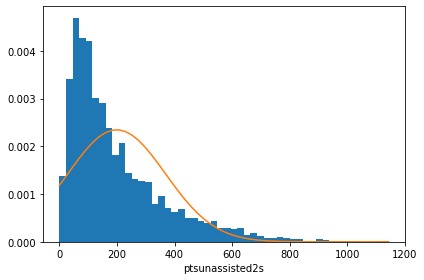


        Summary Stats of: ptsunassisted3s
        Mean:  24.85
        Median:  6.00
        Standard Deviation:  49.84
        


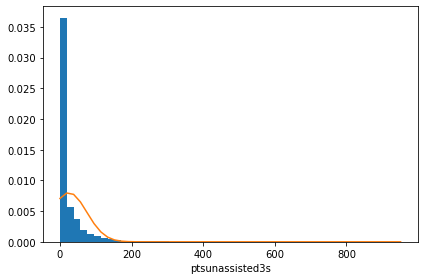


        Summary Stats of: ws/48
        Mean:  0.10
        Median:  0.09
        Standard Deviation:  0.05
        


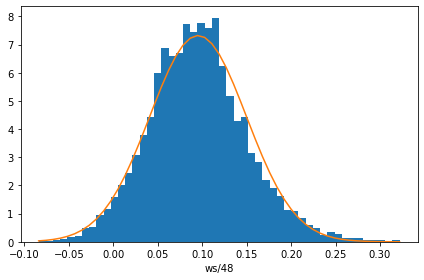


        Summary Stats of: ows
        Mean:  1.91
        Median:  1.40
        Standard Deviation:  2.20
        


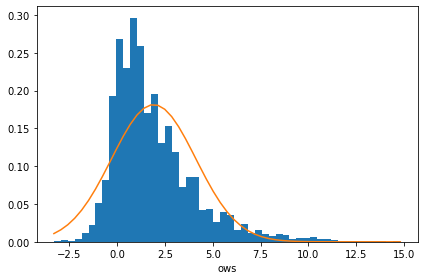


        Summary Stats of: obpm
        Mean: -0.41
        Median: -0.50
        Standard Deviation:  2.37
        


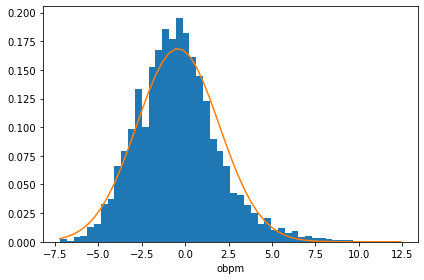


        Summary Stats of: per
        Mean:  14.33
        Median:  13.90
        Standard Deviation:  4.24
        


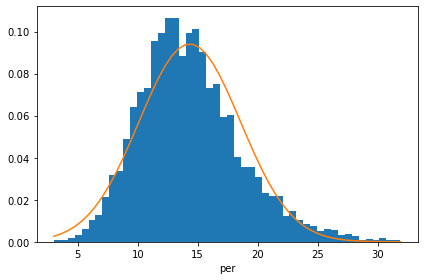

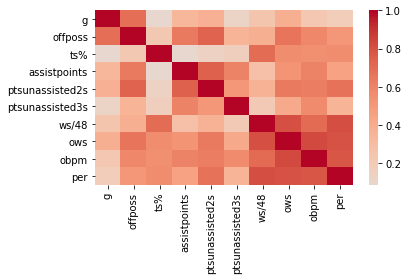

In [42]:
# Stats
sumstat(['g','offposs','ts%', 'assistpoints', 'ptsunassisted2s', 'ptsunassisted3s',
         'ws/48', 'ows', 'obpm', 'per'])

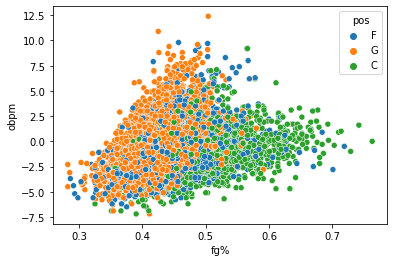

In [43]:
# OBPM Scatter
sns.scatterplot(
    x = nba.loc[:,'fg%'],
    y = nba.loc[:,'obpm'],
    hue = nba.pos
)
plt.show()

In [79]:
def nVarLinRegbyPos(xvar, yvar):
    '''
    xvar = list of length n (where n >= 1) containing column names
    yvar = list of length 1 containing one column name 
    '''
    colors = ['lightskyblue','tab:green','red']
    for i in np.arange(len(nba.pos.unique())):
        position = nba.pos.unique()[i]
        grouped_x = nba.groupby('pos').get_group(position).loc[:,xvar]
        grouped_y = nba.groupby('pos').get_group(position).loc[:,yvar]
        multi_model = LinearRegression()
        multi_model.fit(grouped_x[xvar], grouped_y[yvar])
        r2 = multi_model.score(grouped_x[xvar], grouped_y[yvar])
        print(f'For {position}: R^2 between {xvar} and {yvar}: {r2 : .4f}')
        # Scatterplots
        for j in range(0,len(xvar)):
            fig, ax = plt.subplots()
            ax.scatter(
                grouped_x[xvar[j]],
                multi_model.predict(grouped_x), # plot predicted vs. the column corresponding to the jth entry in xvar
                color = colors[i],
                alpha = 0.3)
            ax.set_xlabel(xvar)
            ax.set_ylabel(yvar)
            ax.set_title(position)
            plt.tight_layout()
            plt.show()

For F: R^2 between ['ptsunassisted2s', 'ts%'] and ['obpm']:  0.6354


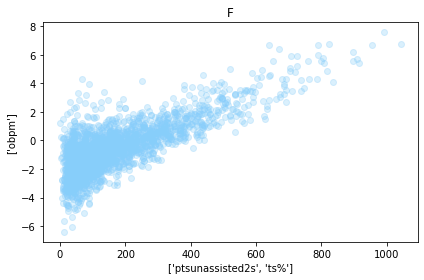

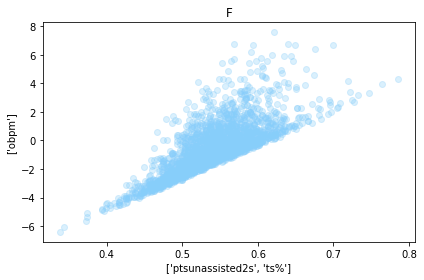

For G: R^2 between ['ptsunassisted2s', 'ts%'] and ['obpm']:  0.6551


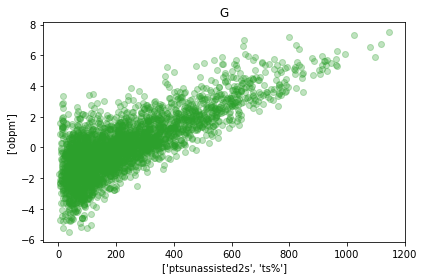

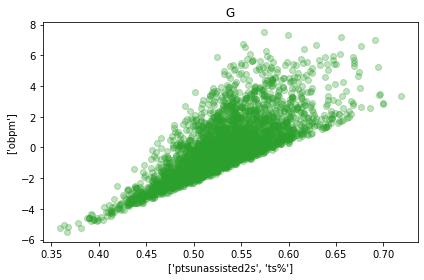

For C: R^2 between ['ptsunassisted2s', 'ts%'] and ['obpm']:  0.6097


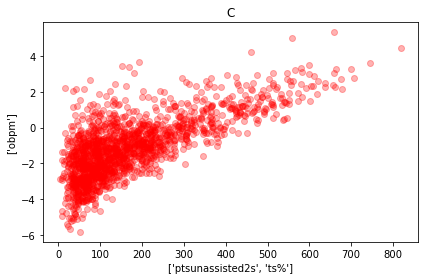

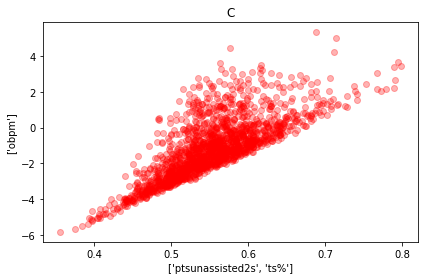

In [45]:
nVarLinRegbyPos(['ptsunassisted2s', 'ts%'], ['obpm'])

For F: R^2 between ['assistpoints'] and ['obpm']:  0.4067


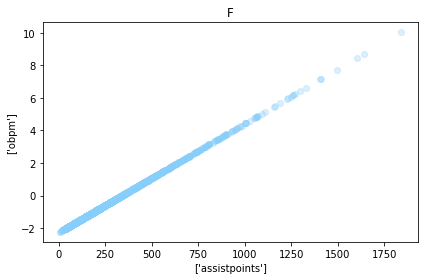

For G: R^2 between ['assistpoints'] and ['obpm']:  0.3675


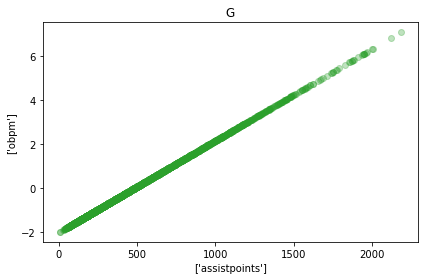

For C: R^2 between ['assistpoints'] and ['obpm']:  0.3708


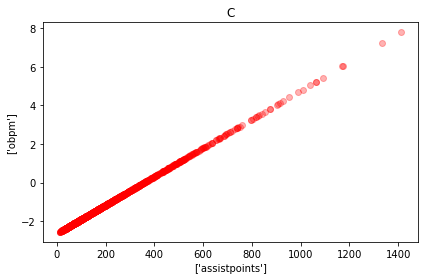

In [46]:
nVarLinRegbyPos(['assistpoints'], ['obpm'])

In [47]:
def corr_scatter(xvar, yvar):
    colors = ['lightskyblue','tab:green','red']
    for i in np.arange(len(nba.pos.unique())):
        position = nba.pos.unique()[i]
        # Corr
        x = nba.groupby('pos').get_group(position).loc[:,xvar]
        y = nba.groupby('pos').get_group(position).loc[:,yvar]
        corr = x.corr(y)
        print(f'For {position}: correlation between {xvar} and {yvar}: {corr : .4f}')
        # Scatter
        fig, ax = plt.subplots()
        ax.scatter(
            list(nba.groupby('pos').get_group(position).loc[:,xvar]),
            nba.groupby('pos').get_group(position).loc[:,yvar],
            color = colors[i],
            alpha = 0.3)
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)
        ax.set_title(position)
        plt.tight_layout()
        plt.show()

For F: correlation between ts% and ws/48:  0.6897


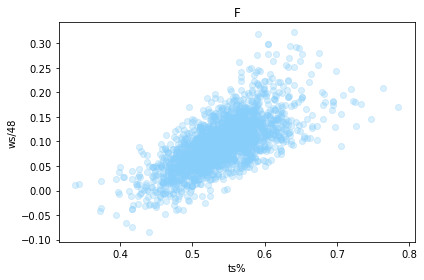

For G: correlation between ts% and ws/48:  0.6937


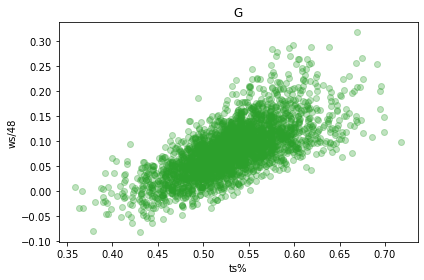

For C: correlation between ts% and ws/48:  0.6833


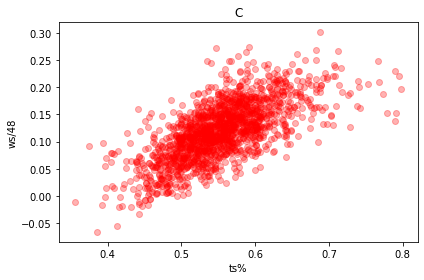

In [48]:
# Testing vars
corr_scatter('ts%','ws/48')

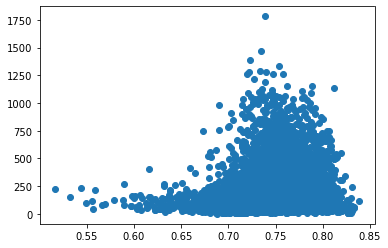

In [89]:
plt.figure()
plt.scatter(1 - (nba['shotqualityavg'])**2, nba['ptsunassisted2s'] + nba['ptsunassisted3s'])
plt.show()

## Analysis

### Creating Our Statistic

In [36]:
# Creating a new df to calculate and store the expected value of shots from 0-3 ft, 3-10 ft, 10-16 ft, 
# 16 ft to the 3PT line, corner 3s, and arc 3s for each individual season...
expected_values_by_loc = lg_avg_shooting.copy()
# Need to find % 3PA from arc (non-corner) and Arc 3PM %
expected_values_by_loc['pct_3pa_arc'] = 1 - expected_values_by_loc['pct_3pa_corner']
# Now, using the fact that overall 3PM % is a weighted average of arc and corner 3PM %, we know that...
expected_values_by_loc['pct_3pm_arc'] = round(((expected_values_by_loc['pct_3pm'] - 
                                        (expected_values_by_loc['pct_3pm_corner']*
                                         expected_values_by_loc['pct_3pa_corner']))/expected_values_by_loc['pct_3pa_arc']),3)
expected_values_by_loc

,season,pct_2pm,pct_fgm_0to3_ft,pct_fgm_3to10_ft,pct_fgm_10to16_ft,pct_fgm_16ftto3pt,pct_3pm,pct_2pm_assisted,pct_3pm_assisted,pct_3pa_corner,pct_3pm_corner,pct_3pa_arc,pct_3pm_arc
1,2021,0.530,0.675,0.428,0.435,0.409,0.367,0.502,0.826,0.222,0.395,0.778,0.359
2,2020,0.524,0.667,0.396,0.416,0.404,0.358,0.504,0.815,0.211,0.390,0.789,0.349
3,2019,0.520,0.658,0.400,0.413,0.401,0.355,0.513,0.823,0.214,0.383,0.786,0.347
4,2018,0.510,0.658,0.394,0.415,0.400,0.362,0.499,0.830,0.208,0.394,0.792,0.354
5,2017,0.503,0.631,0.414,0.412,0.403,0.358,0.495,0.835,0.228,0.388,0.772,0.349
6,2016,0.491,0.624,0.396,0.405,0.398,0.354,0.510,0.836,0.248,0.377,0.752,0.346
7,2015,0.485,0.627,0.384,0.403,0.394,0.350,0.520,0.843,0.254,0.387,0.746,0.337
8,2014,0.488,0.636,0.390,0.401,0.395,0.360,0.518,0.837,0.248,0.390,0.752,0.350
9,2013,0.483,0.631,0.381,0.395,0.393,0.359,0.535,0.851,0.268,0.390,0.732,0.348
10,2012,0.477,0.634,0.378,0.388,0.388,0.349,0.518,0.843,0.261,0.376,0.739,0.339


In the above cell, we created a new DataFrame expected_values_by_loc which will contain the expected value of shots from various locations on the floor for each season in our dataset. Furthermore, we created two columns which were not present in our read-in data "pct_3pa_arc" and "pct_3pm_arc", which contains the league average percentage of 3s taken that were not in the corner and the conversion rate of non-corner 3s by season.

In [37]:
# Now, finding the expected values...
expected_values_by_loc['ev_0to3ft'] = 2*(expected_values_by_loc['pct_fgm_0to3_ft'])
expected_values_by_loc['ev_3to10ft'] = 2*(expected_values_by_loc['pct_fgm_3to10_ft'])
expected_values_by_loc['ev_10to16ft'] = 2*(expected_values_by_loc['pct_fgm_10to16_ft'])
expected_values_by_loc['ev_16ftto3pt'] = 2*(expected_values_by_loc['pct_fgm_16ftto3pt'])
expected_values_by_loc['ev_3pt_corner'] = 3*(expected_values_by_loc['pct_3pm_corner'])
expected_values_by_loc['ev_3pt_arc'] = 3*(expected_values_by_loc['pct_3pm_arc'])
expected_values_by_loc

,season,pct_2pm,pct_fgm_0to3_ft,pct_fgm_3to10_ft,pct_fgm_10to16_ft,pct_fgm_16ftto3pt,pct_3pm,pct_2pm_assisted,pct_3pm_assisted,pct_3pa_corner,pct_3pm_corner,pct_3pa_arc,pct_3pm_arc,ev_0to3ft,ev_3to10ft,ev_10to16ft,ev_16ftto3pt,ev_3pt_corner,ev_3pt_arc
1,2021,0.530,0.675,0.428,0.435,0.409,0.367,0.502,0.826,0.222,0.395,0.778,0.359,1.350,0.856,0.870,0.818,1.185,1.077
2,2020,0.524,0.667,0.396,0.416,0.404,0.358,0.504,0.815,0.211,0.390,0.789,0.349,1.334,0.792,0.832,0.808,1.170,1.047
3,2019,0.520,0.658,0.400,0.413,0.401,0.355,0.513,0.823,0.214,0.383,0.786,0.347,1.316,0.800,0.826,0.802,1.149,1.041
4,2018,0.510,0.658,0.394,0.415,0.400,0.362,0.499,0.830,0.208,0.394,0.792,0.354,1.316,0.788,0.830,0.800,1.182,1.062
5,2017,0.503,0.631,0.414,0.412,0.403,0.358,0.495,0.835,0.228,0.388,0.772,0.349,1.262,0.828,0.824,0.806,1.164,1.047
6,2016,0.491,0.624,0.396,0.405,0.398,0.354,0.510,0.836,0.248,0.377,0.752,0.346,1.248,0.792,0.810,0.796,1.131,1.038
7,2015,0.485,0.627,0.384,0.403,0.394,0.350,0.520,0.843,0.254,0.387,0.746,0.337,1.254,0.768,0.806,0.788,1.161,1.011
8,2014,0.488,0.636,0.390,0.401,0.395,0.360,0.518,0.837,0.248,0.390,0.752,0.350,1.272,0.780,0.802,0.790,1.170,1.050
9,2013,0.483,0.631,0.381,0.395,0.393,0.359,0.535,0.851,0.268,0.390,0.732,0.348,1.262,0.762,0.790,0.786,1.170,1.044
10,2012,0.477,0.634,0.378,0.388,0.388,0.349,0.518,0.843,0.261,0.376,0.739,0.339,1.268,0.756,0.776,0.776,1.128,1.017


In [38]:
# Removing all unnecessary, extraneous columns from expected_values_by_loc...
expected_values_by_loc = expected_values_by_loc.loc[:,['season','ev_0to3ft', 'ev_3to10ft', 'ev_10to16ft',
                                                       'ev_16ftto3pt', 'ev_3pt_corner', 'ev_3pt_arc']]
expected_values_by_loc

,season,ev_0to3ft,ev_3to10ft,ev_10to16ft,ev_16ftto3pt,ev_3pt_corner,ev_3pt_arc
1,2021,1.350,0.856,0.870,0.818,1.185,1.077
2,2020,1.334,0.792,0.832,0.808,1.170,1.047
3,2019,1.316,0.800,0.826,0.802,1.149,1.041
4,2018,1.316,0.788,0.830,0.800,1.182,1.062
5,2017,1.262,0.828,0.824,0.806,1.164,1.047
6,2016,1.248,0.792,0.810,0.796,1.131,1.038
7,2015,1.254,0.768,0.806,0.788,1.161,1.011
8,2014,1.272,0.780,0.802,0.790,1.170,1.050
9,2013,1.262,0.762,0.790,0.786,1.170,1.044
10,2012,1.268,0.756,0.776,0.776,1.128,1.017


In the above two cells, we calculated and put into columns the expected value of shots from six different areas on the court for every season in our dataset (2000-2001 through 2020-2021) and then removed unnecessary columns from our DataFrame which contains the aforementioned expecrted values.

In [130]:
# Finally, before continuning, let's set the index of this df to be the season column.
expected_values_by_loc = expected_values_by_loc.set_index('season')
expected_values_by_loc

,ev_0to3ft,ev_3to10ft,ev_10to16ft,ev_16ftto3pt,ev_3pt_corner,ev_3pt_arc
season,,,,,,
2021,1.350,0.856,0.870,0.818,1.185,1.077
2020,1.334,0.792,0.832,0.808,1.170,1.047
2019,1.316,0.800,0.826,0.802,1.149,1.041
2018,1.316,0.788,0.830,0.800,1.182,1.062
2017,1.262,0.828,0.824,0.806,1.164,1.047
2016,1.248,0.792,0.810,0.796,1.131,1.038
2015,1.254,0.768,0.806,0.788,1.161,1.011
2014,1.272,0.780,0.802,0.790,1.170,1.050
2013,1.262,0.762,0.790,0.786,1.170,1.044


In [131]:
nba.columns

Index(['season', 'player', 'age', 'tm', 'g', 'gs', 'gs%', 'mp', 'per', 'ts%',
       '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%',
       'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp',
       'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%',
       'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts', 'offposs', 'nonheavefg3pct', 'ftpoints', 'ptsassisted2s',
       'ptsunassisted2s', 'ptsassisted3s', 'ptsunassisted3s', 'assisted2spct',
       'nonputbacksassisted2spct', 'assisted3spct', 'shotqualityavg',
       'ptsputbacks', 'fg2ablocked', 'fg2apctblocked', 'fg3ablocked',
       'fg3apctblocked', 'assistpoints', 'twoptassists', 'threeptassists',
       'atrimassists', 'shortmidrangeassists', 'longmidrangeassists',
       'corner3assists', 'arc3assists', 'pos'],
      dtype='object')

In [250]:
lg_avg_shooting

,season,pct_fga_2p,pct_fga_3to10_ft,pct_fga_10to16_ft,pct_2pm,pct_fgm_0to3_ft,pct_fgm_3to10_ft,pct_fgm_10to16_ft,pct_fgm_16ftto3pt,pct_3pm,pct_2pm_assisted,pct_3pm_assisted,pct_3pa_corner,pct_3pm_corner
1,2021,0.608,0.186,0.096,0.530,0.675,0.428,0.435,0.409,0.367,0.502,0.826,0.222,0.395
2,2020,0.616,0.165,0.093,0.524,0.667,0.396,0.416,0.404,0.358,0.504,0.815,0.211,0.390
3,2019,0.641,0.162,0.096,0.520,0.658,0.400,0.413,0.401,0.355,0.513,0.823,0.214,0.383
4,2018,0.663,0.156,0.106,0.510,0.658,0.394,0.415,0.400,0.362,0.499,0.830,0.208,0.394
5,2017,0.684,0.152,0.099,0.503,0.631,0.414,0.412,0.403,0.358,0.495,0.835,0.228,0.388
6,2016,0.715,0.158,0.103,0.491,0.624,0.396,0.405,0.398,0.354,0.510,0.836,0.248,0.377
7,2015,0.732,0.164,0.103,0.485,0.627,0.384,0.403,0.394,0.350,0.520,0.843,0.254,0.387
8,2014,0.741,0.169,0.105,0.488,0.636,0.390,0.401,0.395,0.360,0.518,0.837,0.248,0.390
9,2013,0.757,0.164,0.107,0.483,0.631,0.381,0.395,0.393,0.359,0.535,0.851,0.268,0.390
10,2012,0.774,0.169,0.110,0.477,0.634,0.378,0.388,0.388,0.349,0.518,0.843,0.261,0.376


In [43]:
teamstats.columns

Index(['rank', 'team', 'age', 'wins', 'losses', 'pw', 'pl', 'mov', 'sos',
       'srs', 'ortg', 'drtg', 'nrtg', 'pace', 'ftr', '3par', 'ts%', 'efg%',
       'tov%', 'orb%', 'ft/fga', 'efg%.1', 'tov%.1', 'drb%', 'ft/fga.1',
       'attend.', 'attend./g', 'season'],
      dtype='object')

In [236]:
expected_values_by_loc

,ev_0to3ft,ev_3to10ft,ev_10to16ft,ev_16ftto3pt,ev_3pt_corner,ev_3pt_arc,estev_3to16ft
season,,,,,,,
2021,1.350,0.856,0.870,0.818,1.185,1.077,NaN
2020,1.334,0.792,0.832,0.808,1.170,1.047,NaN
2019,1.316,0.800,0.826,0.802,1.149,1.041,NaN
2018,1.316,0.788,0.830,0.800,1.182,1.062,NaN
2017,1.262,0.828,0.824,0.806,1.164,1.047,NaN
2016,1.248,0.792,0.810,0.796,1.131,1.038,NaN
2015,1.254,0.768,0.806,0.788,1.161,1.011,NaN
2014,1.272,0.780,0.802,0.790,1.170,1.050,NaN
2013,1.262,0.762,0.790,0.786,1.170,1.044,NaN


Note that pbpstats classifies short mid-range shots as shots from 4-14 ft away from the basket and long mid-range as coming from 14 ft away from the basket to the three point line. Because of how the Basketball Reference league average shooting data is broken up, we will have to define short mid-range as shots coming from 3-16 ft away and long mid-range as coming from 16 ft away to the three point line. Looking at the percentages in our lg_avg_shooting DataFrame, this re-classification should not alter our results significantly.

In [257]:
# Adjusting for reclassification
for i in range(1,22):
    expected_values_by_loc.loc[2022-i,'estev_3to16ft'] = (((lg_avg_shooting.loc[i,'pct_fga_3to10_ft']/(lg_avg_shooting.loc[i,'pct_fga_3to10_ft'] 
                                                            + lg_avg_shooting.loc[i,'pct_fga_10to16_ft']))*expected_values_by_loc.loc[2022-i,'ev_3to10ft']) 
                                                            + ((lg_avg_shooting.loc[i,'pct_fga_10to16_ft']/(lg_avg_shooting.loc[i,'pct_fga_3to10_ft'] 
                                                            + lg_avg_shooting.loc[i,'pct_fga_10to16_ft']))*expected_values_by_loc.loc[2022-i,'ev_10to16ft']))
expected_values_by_loc

,ev_0to3ft,ev_3to10ft,ev_10to16ft,ev_16ftto3pt,ev_3pt_corner,ev_3pt_arc,estev_3to16ft
season,,,,,,,
2021,1.350,0.856,0.870,0.818,1.185,1.077,0.860766
2020,1.334,0.792,0.832,0.808,1.170,1.047,0.806419
2019,1.316,0.800,0.826,0.802,1.149,1.041,0.809674
2018,1.316,0.788,0.830,0.800,1.182,1.062,0.804992
2017,1.262,0.828,0.824,0.806,1.164,1.047,0.826422
2016,1.248,0.792,0.810,0.796,1.131,1.038,0.799103
2015,1.254,0.768,0.806,0.788,1.161,1.011,0.782659
2014,1.272,0.780,0.802,0.790,1.170,1.050,0.788431
2013,1.262,0.762,0.790,0.786,1.170,1.044,0.773055


In [316]:
# Piece-by-piece building of our statistic
nba_groups = nba.groupby('season')
si_scoring_factor = pd.Series([], dtype = float)
si_playmaking_factor = pd.Series([], dtype = float)
for name, group in nba_groups:
    si_scoring_factor = si_scoring_factor.append(((1 - (group['shotqualityavg']))*(group['efg%'] - lg_avg_teamstats.loc[name, 'efg%'])
                            *(group['ptsunassisted2s'] + group['ptsunassisted3s'])) + (group['ft%'] - 
                            (lg_avg_teamstats.loc[name, 'ft'])/lg_avg_teamstats.loc[name, 'fta'])*group['ftpoints'])
    si_playmaking_factor = si_playmaking_factor.append((1.5 - (group['tov%']/lg_avg_teamstats.loc[name, 'tov%']))
                                *((group['atrimassists']*(expected_values_by_loc.loc[name,'ev_0to3ft']))
                                + (group['shortmidrangeassists']*(expected_values_by_loc.loc[name,'estev_3to16ft']))
                                + (group['longmidrangeassists']*(expected_values_by_loc.loc[name,'ev_16ftto3pt']))
                                + (group['corner3assists']*(expected_values_by_loc.loc[name,'ev_3pt_corner']))
                                + (group['arc3assists']*(expected_values_by_loc.loc[name,'ev_3pt_arc']))))
nba['si_scoring_factor'] = si_scoring_factor
nba['si_playmaking_factor'] = (1/4.5)*si_playmaking_factor
nba['si_unadjusted'] = nba['si_scoring_factor'] + nba['si_playmaking_factor']
# Adjusting for player USG%..
nba['uSI_offense'] = (1 - np.log(nba['usg%']/20))*nba['si_unadjusted']
# Adjusting for pace...
nba['pace_estimate'] = (48*nba['offposs'])/nba['mp']
nba_groups = nba.groupby('season')
si_offense = pd.Series([], dtype = float)
for name, group in nba_groups:
    si_offense = si_offense.append((1-np.log(group['pace_estimate']/lg_avg_teamstats.loc[name,'pace']))*group['uSI_offense'])
nba['si_offense'] = si_offense    

In [317]:
nba.sort_values(by = 'si_offense', ascending = False)

,season,player,age,tm,g,gs,gs%,mp,per,ts%,...,corner3assists,arc3assists,pos,si_scoring_factor,si_playmaking_factor,si_unadjusted,uSI,pace_estimate,uSI_offense,si_offense
1515,2006,Chauncey Billups,29,DET,81,81,1.000,2925,23.4,0.602,...,51,103,G,75.350608,95.669577,171.020184,437.367411,86.547692,147.863258,154.465979
4564,2015,Chris Paul,29,LAC,82,82,1.000,2857,26.0,0.596,...,76,156,G,69.653072,106.117497,175.770569,454.301650,94.941547,145.934785,144.324975
2332,2008,Chris Paul,22,NOH,80,80,1.000,3006,28.3,0.576,...,103,170,G,46.967606,125.986054,172.953660,459.962855,91.033932,129.584022,131.514132
2159,2008,Jose Calderon,26,TOR,82,56,0.683,2484,20.5,0.607,...,67,131,G,37.580039,64.606399,102.186438,385.550593,89.700483,120.002990,123.561177
2137,2008,Chauncey Billups,31,DET,78,78,1.000,2522,23.6,0.619,...,36,85,G,74.009720,60.061559,134.071278,296.168550,87.226011,115.333216,121.979223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,2011,Rajon Rondo,24,BOS,68,68,1.000,2527,17.1,0.495,...,58,94,G,-17.973991,-56.445028,-74.419019,-296.136631,91.365255,-81.029751,-81.678773
4827,2016,DeAndre Jordan,27,LAC,77,77,1.000,2598,20.6,0.628,...,11,16,C,-76.921487,12.202247,-64.719240,-27.764373,95.390300,-81.634569,-81.984437
4910,2016,Rajon Rondo,29,SAC,72,72,1.000,2537,16.9,0.506,...,60,135,G,-17.507267,-73.864966,-91.372233,-371.549792,100.673236,-97.025926,-92.211762
5808,2019,Draymond Green,28,GSW,66,66,1.000,2065,12.9,0.526,...,39,122,F,-5.688402,-73.274054,-78.962456,-477.345265,101.206780,-112.373054,-111.025076


In [318]:
nba.describe()

,season,age,g,gs,gs%,mp,per,ts%,3par,ftr,...,longmidrangeassists,corner3assists,arc3assists,si_scoring_factor,si_playmaking_factor,si_unadjusted,uSI,pace_estimate,uSI_offense,si_offense
count,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,...,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000,6717.000000
mean,2011.345243,26.692124,65.583892,35.396755,0.524191,1656.541760,14.334286,0.538423,0.253433,0.283493,...,31.935090,13.853506,30.208873,2.045237,16.573518,18.618755,71.187337,93.533222,16.574045,16.557413
std,6.066982,4.152242,14.044810,28.731494,0.391979,699.215797,4.239232,0.053044,0.206602,0.135339,...,36.053513,14.601577,28.473481,14.926390,16.287879,26.626130,69.847912,4.449126,22.571949,22.544803
min,2001.000000,19.000000,15.000000,0.000000,0.000000,375.000000,3.000000,0.338000,0.000000,0.020000,...,0.000000,0.000000,0.000000,-81.284566,-145.897220,-147.134297,-936.092170,4.046838,-209.389767,-201.668406
25%,2006.000000,24.000000,57.000000,7.000000,0.123000,1063.000000,11.400000,0.505000,0.029000,0.189000,...,9.000000,4.000000,11.000000,-5.173621,5.728461,2.240283,25.852204,90.673768,2.603481,2.651443
50%,2012.000000,26.000000,68.000000,29.000000,0.491000,1617.000000,13.900000,0.536000,0.255000,0.260000,...,19.000000,9.000000,21.000000,-0.090956,12.728363,12.206081,60.034495,93.079848,13.105170,13.094744
75%,2017.000000,30.000000,77.000000,64.000000,0.986000,2186.000000,16.700000,0.570000,0.410000,0.352000,...,40.000000,18.000000,39.000000,6.821884,24.019772,29.206483,110.096972,96.164303,28.622750,28.580195
max,2021.000000,43.000000,85.000000,83.000000,1.000000,3443.000000,31.900000,0.798000,0.914000,1.219000,...,351.000000,161.000000,272.000000,126.993598,125.986054,186.387546,459.962855,107.025743,147.863258,154.465979


In [305]:
# Finding the proper scalar to weigh playmaking factor by...
aPlayMake = 1/4.5*(si_playmaking_factor)
aPlayMake.describe()

count    6717.000000
mean       16.573518
std        16.287879
min      -145.897220
25%         5.728461
50%        12.728363
75%        24.019772
max       125.986054
dtype: float64

## Data Description and Limitations

### Data Description

For what purpose was the dataset created? Was there a specific task in mind? Was there a specific gap that needed to be filled? Please provide a description.

    The dataset was created with the purpose of being used to create a new statistic to evaluate an NBA player's ability to induce and convert offensive opportunities for himself, as well as leading teammates to those opportunities, on a per season basis. This statistic could specifically be used by NBA front offices to make personnel decisions, such as signing or trading for a player, as well as by coaches to prepare for opposing teams and players. 

Who created the dataset (e.g., which team, research group) and on behalf of which entity (e.g., company, institution, organization)? Who funded the creation of the dataset? If there is an associated grant, please provide the name of the grantor and the grant name and number.

    N/A		

What do the instances that comprise the dataset represent (e.g., documents, photos, people, countries)? Are there multiple types of instances (e.g., movies, users, and ratings; people and interactions be- tween them; nodes and edges)? Please provide a description.

    Each instance represents an NBA player during a single season. Thus, many players are represented by multiple instances in the dataset. For example, LeBron James has played in every season since the 2003-2004 season. So, each seasonal version of James is contained within its own instance. 

How many instances are there in total (of each type, if appropriate).

    There are 6,717 instances in total.

Does the dataset contain all possible instances or is it a sample (not necessarily random) of instances from a larger set? If the dataset is a sample, then what is the larger set? Is the sample representa- tive of the larger set (e.g., geographic coverage)? If so, please describe how this representativeness was validated/verified. If it is not representative of the larger set, please describe why not (e.g., to cover a more diverse range of instances, because instances were withheld or unavailable).

    The dataset contains all NBA players that played in any season from the 2000-2001 season to the 2020-2021 season. Furthermore, the dataset is restricted to players above the 30th percentile in minutes played in each of those seasons. This is due to a few reasons. The first, and primary, reason is because some of our data was not available for many players whose minutes played placed them below the cutoff. Additionally, per-possession and existing advanced statistics are subject to extreme noise when examined for players with lower amounts of minutes played, as these small sample sizes are not representative of a player’s true ability and are often strongly influenced by external factors.
    Furthermore, we restricted our dataset to include players only from the past 20 seasons because some of the data, which we believe to make a rather significant difference in the accuracy of our statistic, is only available for players who played in the 2000-2001 season or later.

What data does each instance consist of? “Raw” data (e.g., unpro- cessed text or images) or features? In either case, please provide a description.

    Each instance consists of numerical values describing a player’s seasonal performance, as well as categorical values describing the player himself. The following features are present for each instance in the dataset: https://drive.google.com/drive/folders/1IhxZATJ3L_053bhfZfvgzClR9FXLLeF7.

Is any information missing from individual instances? If so, please provide a description, explaining why this information is missing (e.g., because it was unavailable). This does not include intentionally removed information, but might include, e.g., redacted text.

    There is not any information missing from individual instances.

Are relationships between individual instances made explicit (e.g., users’ movie ratings, social network links)? If so, please de- scribe how these relationships are made explicit.

    Relationships between individual instances are not made explicit.

Are there recommended data splits (e.g., training, development/validation, testing)? If so, please provide a description of these splits, explaining the rationale behind them.	

    There are no recommended data splits.

Are there any errors, sources of noise, or redundancies in the dataset? If so, please provide a description.

    There are no errors, sources of noise, or redundancies in the dataset.

Is the dataset self-contained, or does it link to or otherwise rely on external resources (e.g., websites, tweets, other datasets)? If it links to or relies on external resources, a) are there guarantees that they will exist, and remain constant, over time; b) are there official archival versions of the complete dataset (i.e., including the external resources as they existed at the time the dataset was created); c) are there any restrictions (e.g., licenses, fees) associated with any of the external resources that might apply to a future user? Please provide descriptions of all external resources and any restrictions associated with them, as well as links or other access points, as appropriate. 

    The dataset relies on external resources. The external resources relied upon are called Stathead Basketball (via Sports Reference, LLC) and PBP Stats. 
    Stathead Basketball is a powerful, highly regarded sports research tool. Starting with the 2018-2019 season, all data is official NBA data provided by SportRadar, the official statistics partner of the NBA. For seasons prior to 2018-2019, the data is official NBA data entered, maintained, and updated by Sports Reference employees. For our data from Stathead Basketball from the 2017-2018 season to the 2020-2021 season, we gathered it directly from the site using its Player Season Finder tool. However, Stathead is a subscription-based service, so users without a paid subscription will not be able to obtain the data directly through Stathead (https://stathead.com/basketball/). However, for all seasons prior to the 2017-2018 season, we obtained the same data we would have through Stathead itself from an already created dataset found on Kaggle (https://www.kaggle.com/drgilermo/nba-players-stats) which was used for a different project. This dataset was obtained by scraping Basketball Reference, which is the site that hosts Stathead Basketball.
    PBP Stats is another highly regarded sports research tool. All of the data it utilizes is from data.nba.com and stats.nba.com, which both contain basically the same data, albeit with the following small differences, according to PBP Stats creator Darryl Blackport: “The data.nba.com play-by-play has the offense team id in all events, which makes it easier to track possession changes. The stats.nba.com events do not have this attribute and to get possession counts the play-by-play needs to be parsed, which makes it more sensitive to events being in the correct order. The stats.nba.com play-by-play also has lots of shots and rebounds that are out of order that need to be fixed manually. If you download the data from the link above, I have fixed these for previous seasons, but going forward if you use this you will have to keep up with fixing them manually yourself. If you don’t care if there may be an occasional possession count being off or you don’t want to deal with manually fixing the event order I suggest using data.nba.com for your play-by-play provider…” additionally, “stats.nba.com has more older season data available, and “the data.nba.com play-by-play updates in real time” (https://pbpstats.readthedocs.io/_/downloads/en/v1.1.2/pdf/). All of the data we collected from PBP Stats (http://www.pbpstats.com/) is accessible by, from the home page, selecting “Totals” and then “Player”. The tables we utilized were the “Scoring” and the “Assists” tables for every season available.

Does the dataset contain data that might be considered confiden- tial (e.g., data that is protected by legal privilege or by doctor- patient confidentiality, data that includes the content of individu- als’ non-public communications)? If so, please provide a description.

    The dataset does not contain data that might be considered confidential.

Does the dataset contain data that, if viewed directly, might be of- fensive, insulting, threatening, or might otherwise cause anxiety? If so, please describe why.

    The dataset does not contain data that might be offensive, insulting, threatening, or cause anxiety in any other way.

Does the dataset relate to people? If not, you may skip the remaining questions in this section.

    Yes, the dataset relates to people.

Does the dataset identify any subpopulations (e.g., by age, gen- der)? If so, please describe how these subpopulations are identified and provide a description of their respective distributions within the dataset. Is it possible to identify individuals (i.e., one or more natural per- sons), either directly or indirectly (i.e., in combination with other data) from the dataset? If so, please describe how.

    The dataset does not identify any subpopulations.	

Does the dataset contain data that might be considered sensitive in any way (e.g., data that reveals racial or ethnic origins, sexual orientations, religious beliefs, political opinions or union mem- berships, or locations; financial or health data; biometric or ge- netic data; forms of government identification, such as social se- curity numbers; criminal history)? If so, please provide a description. 

    The dataset does not contain data that might be considered sensitive in any way.

How was the data associated with each instance acquired? Was the data directly observable (e.g., raw text, movie ratings), reported by subjects (e.g., survey responses), or indirectly inferred/derived from other data (e.g., part-of-speech tags, model-based guesses for age or language)? If data was reported by subjects or indirectly inferred/derived from other data, was the data validated/verified? If so, please describe how.

    The data associated with each instance was acquired by downloading and reading in a CSV containing the data for that particular instance from Stathead 	(or, just by reading it in if that particular instance corresponded to a player from before the 2017-2018 season) and reading in CSVs containing the data for that particular instance from the PBP “Scoring” and “Assists” tables. Each feature in the dataset is either directly observable or derived from directly observable data.

Does the dataset relate to people? If not, you may skip the remainder of the questions in this section. 

    Yes, the dataset relates to people.				

Did you collect the data from the individuals in question directly, or obtain it via third parties or other sources (e.g., websites)?

    The data was collected via other sources.

Was the “raw” data saved in addition to the preprocessed/cleaned/labeled data (e.g., to support unanticipated future uses)? If so, please provide a link or other access point to the “raw” data.

    The “raw” data can be found here: https://drive.google.com/drive/folders/1IhxZATJ3L_053bhfZfvgzClR9FXLLeF7.

Has the dataset been used for any tasks already? If so, please provide a description.

    The entire dataset has not been used for any tasks yet.

What (other) tasks could the dataset be used for?

    The dataset can be used for many basketball analyses, assuming the analyses require the slight scope limitations that our dataset uses.						

Is there anything about the composition of the dataset or the way it was collected and preprocessed/cleaned/labeled that might im- pact future uses? For example, is there anything that a future user might need to know to avoid uses that could result in unfair treatment of individuals or groups (e.g., stereotyping, quality of service issues) or other undesirable harms (e.g., financial harms, legal risks) If so, please provide a description. Is there anything a future user could do to mitigate these undesirable harms?	

    There is nothing about the composition of the dataset or the way it was collected and cleaned that might impact future uses.	

Are there tasks for which the dataset should not be used? If so, please provide a description.

    Depending on the desired period of analysis, this dataset may not be good for historical player analysis. Since the data only goes back to the 2000-2001 season, if one wished to analyze individual player seasons during the 21st century exclusively, then this dataset would be fine. However, any further back and this dataset will not be great. Furthermore, while certain statistics for certain players present in the dataset could be analyzed from the career-level utilizing this dataset, it's far more useful as a tool to analyze individual seasons of player careers.				
### Data Limitations

    While there are not any true potential harms or data gaps, however, a key limitation of our dataset is the aforementioned fact that it only spans the previous 20 NBA seasons (the 2000-2001 season through the 2020-2021 season). This will not be an issue when our statistic based on this dataset is deployed in the previously mentioned context we envision its primary use to be in, which is for making personnel decisions such as signing a free agent or executing a trade, current season player evaluation, and for game planning purposes. But, it will limit our metric’s use in historical comparisons and all-time player evaluation, as it will only be applied to players who played in the 2000-2001 season or later. However, such tasks are not very important, at least for NBA organizations themselves.

## Preregistration Statement

1. One analysis we will perform is an examination of how our advanced rating statistic depends on their position or archetype. To do this, we will perform k-means clustering using the input parameters of our statistic and the statistic itself. After the clustering is performed, we will look at the density of each position or archetype cluster. This will allow us to determine if there is a need to adjust some or all of the coefficients of our input variables depending on player position or archetype.

2. A second analysis we will perform is a multivariate regression on the player rankings derived from ‘obpm’ values. This will be a basic multivariate model based on Offensive Box Plus-Minus (OBPM),  a popular advanced statistic. The results of this regression task will help inform us in the creation and further analysis of our own advanced statistic. The independent variables in the regression will be unassisted points, which will be a sum of ‘ptsunassisted2s’ and ‘ptsunassisted3s’, ‘assistpoints’, and ‘ts%’. In theory, these 3 variables should be strong indicators of player performance, so we wanted to know the magnitude and significance of their effect on a player’s league-wide ranking.


## Analysis

In [ ]:
# output = a*(ptsunassisted2s) + b*(ptsunassisted3s) + c*(ftpoints) + d*(ts%) + e*(shotqualityavg)